In [1]:
#basic imports ✌

import matplotlib.pyplot as plt
import os
import random
import numpy as np
import math, random
import tensorflow as tf
#os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras as ks
import soundfile as sf
import sounddevice as sd
import python_speech_features

%matplotlib inline
np.random.seed(0)

Using TensorFlow backend.


In [2]:
#Finding speech sample 🤷‍🤷‍🤷‍
class speech:
    
    def choose_random(self):
        path = r"C:\Users\Darius\Desktop\sound samples\training data for RNN\LibriSpeech\train-clean-100"
        for i in range (0,3):
            files = os.listdir(path)
            index = random.randrange(0, len(files))
            while  files[index].endswith('.txt'):
                #index = index + 1
                index = random.randrange(0, len(files))
            path  = os.path.join(path, files[index])
        file_path = path
        self.sample, fs2 = sf.read(file_path)
        
        self.size = len(self.sample)
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)

    def show_sample(self):
        print(file_path)
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [3]:
#Finding noise sample 🎉🎉🎉🎉🎷🎸🎶🎵🎵
class noise:
    def __init__(self,size):
        self.size = size
    
    def choose_random(self):
        path = r"C:\Users\Darius\Desktop\sound samples\training data for RNN\rnnoise_contributions"
        files = os.listdir(path)
        index = random.randrange(0, len(files))
        if  files[index].endswith('.txt'):
            index = index -1
        file_path = os.path.join(path, files[index])
        self.sample, fs = sf.read(file_path, channels=2, samplerate=24100,format='RAW', subtype='PCM_16')

        i=0
        while i!=1:
            random_sequence = random.randrange(0,len(self.sample))
            if random_sequence + self.size < len(self.sample):
                i=1
        self.sample = self.sample[random_sequence:]
        self.sample = self.sample[:self.size ,:1]
        
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)
        
    def show_sample():
        print(file_path)
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [4]:
#making input sample  🎵🎵🤷‍🤷‍
class combined_samples:
    def __init__(self,speech_sample,noise_sample):
        self.speech_sample = speech_sample
        self.noise_sample  = noise_sample
    
    def combine_samples(self):
        self.sample = [len(self.speech_sample)] * 0
        self.sample = np.empty([len(self.speech_sample)])

        for i in range(len(self.speech_sample)):
            self.sample[i] = self.speech_sample[i] + self.noise_sample[i]
        
        self.size = len(self.sample)
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)
        
    def show_sample(self):
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [5]:
# Training Data
class training_data:
    def get_data(self):
        self.speechD = speech()
        self.speechD.choose_random()
        
        self.noiseD = noise(self.speechD.size)
        self.noiseD.choose_random()
        
        self.combined = combined_samples(self.speechD.sample , self.noiseD.sample)
        self.combined.combine_samples()
        
        self.input = self.combined.nfcc
        self.output= self.speechD.nfcc

In [6]:
d = training_data()
d.get_data()

In [33]:
#Creating The GRU NN
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Activation, GRU, Flatten, Embedding

input_dim = 24
max_dim = 2000

model = Sequential()

model.add(Embedding(max_dim, input_dim, input_length=input_dim))

model.add(GRU(input_dim,input_shape=(max_dim,input_dim),activation='tanh',return_sequences=True))
#model.add(GRU(input_dim,input_shape=(input_dim,len(d.input)),activation='tanh',return_sequences=True))
model.add(Dropout(0.15))

model.add(GRU(input_dim,input_shape=(input_dim,max_dim,input_dim),activation='tanh', return_sequences=False))
#model.add(GRU(input_dim,input_shape=(input_dim,len(d.input)),activation='tanh', return_sequences=False))
model.add(Dropout(0.15))

model.add(Dense(units=input_dim))
model.add(Activation("linear"))

model.build()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [34]:
model.summary()

from keras.utils.vis_utils import plot_model
os.environ["PATH"] += os.pathsep + r"\\Users\\Darius\\Desktop\\RNN stuff\\graphviz\\"
import pydot_ng as pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 24)            48000     
_________________________________________________________________
gru_7 (GRU)                  (None, 24, 24)            3528      
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
gru_8 (GRU)                  (None, 24)                3528      
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
activation_4 (Activation)    (None, 24)                0         
Total para

In [36]:
#Training the NN
import progressbar
from tqdm import tqdm
from IPython.display import clear_output
n_epochs = 80000
history=['0']
for i in tqdm(range(n_epochs)):
    model.train_on_batch(d.input,d.output)

    if i%10==0 :
        clear_output(wait=True)
        print("Training Epoch {}".format(i))
        score= model.evaluate(d.input,d.output)
        print(score)
        history.append(score)
        
    if i%50==0 :    
        d.get_data()
    
del history[0:1]

Training Epoch 79990
360/360 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step
[32.18144654168023, 0.6416666666666667]



100%|██████████████████████████████████████████████████████████████████████████| 80000/80000 [5:00:14<00:00, 10.78it/s]


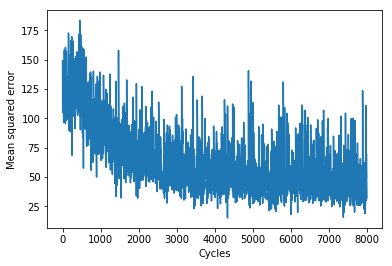

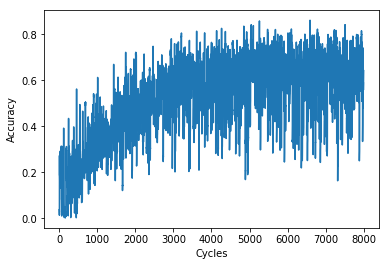

In [37]:
#Check how the NN is doing 
loss = [l[0] for l in history]
accuracy = [l[1] for l in history]

plt.plot(loss)
plt.xlabel('Cycles')
plt.ylabel('Mean squared error')
plt.savefig("error.png")
plt.show()
plt.plot(accuracy)
plt.xlabel('Cycles')
plt.ylabel('Accuracy')
plt.savefig("accuracy.png")

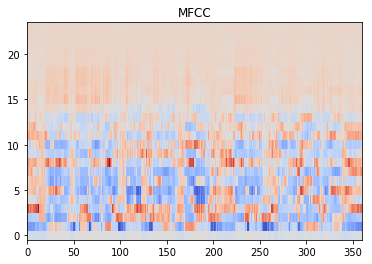

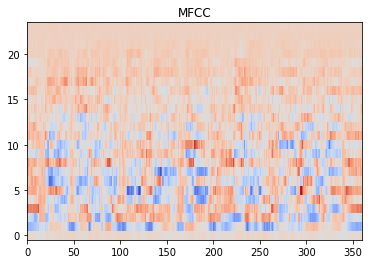

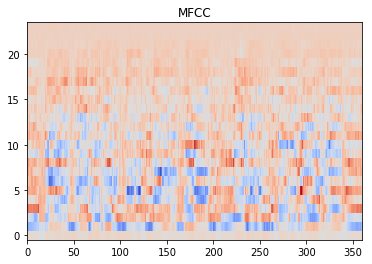

In [38]:
#predictions
pred= model.predict(d.input)
from matplotlib import cm
#Plotting the MFCC diagrams
fig,ax=plt.subplots()
mfcc_data=np.swapaxes(pred,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.show()


fig,ax=plt.subplots()
mfcc_data=np.swapaxes(d.output,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.show()


fig,ax=plt.subplots()
mfcc_data=np.swapaxes(d.input,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.show()

In [39]:
score= model.evaluate(d.input,d.output)
print(score)

360/360 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step
[31.173296440972223, 0.6444444444444445]


In [40]:
model.save('my_model.h5')